# Predict the number of visits in British museums and galleries

Olivier Viollet, April 2019, olivier.viollet[a]gmail.com

## Abstract

This study uses machine learning to predict the number of visits in a given British museum or gallery. On average, the best model's absolute error is slightly above 20,000 people.

Outline :

1. Objective and data preparation 
2. Models
3. Evaluation

## 1. Objective and data preparation

The purpose of this study is to build a model to predict the number of visits in a given British patrimonial institution based on a few predictors, namely : 

- the name of the institution ;
- the year ;
- the month.

Therefore, the models will predict the number of visits at a month level.

To train the models we use the data from the British government platform, updated in February 2019. The data is available at the following link : https://www.gov.uk/government/statistical-data-sets/museums-and-galleries-monthly-visits

We remove observations for which the number of visits is missing as well as those that aggregate the figures of different institutions, denoted by the word "TOTAL". There are 7067 remaining observations, from 2004 to 2018. 

A quick look at the data provides some insights :

- the distribution of the target, i.e. the number of visits, is **rightly skewed**. For about 75 % of the observations the number of visits is under 100,000 but it can go as high as 800,000 for the others. Such a dispersion results in a **high standard deviation (135,000)** and a large gap between the **mean (90,000)** and the **median (30,000)**. Using the natural logarithm for the response will probably help in making predictions even though the distribution remains quite far from a Gaussian one ;
- the number of visits is slightly higher during **summer** ;
- the number of visits tends to **increase over the years** ;
- the number of visits is **extremely different from one institution to another**, the British museum, the Tate and the National Gallery getting the highest figures.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error

import lightgbm as lgb

# function to recode
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [3]:
museums = pd.read_csv('Museums_and_galleries_monthly_visitor_figures_December_2018.csv', 
                     encoding = 'iso-8859-1', sep = ',')
print(museums.info())
museums.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 4 columns):
museum      10090 non-null object
year        10090 non-null int64
month       10090 non-null int64
 visits     10090 non-null object
dtypes: int64(2), object(2)
memory usage: 315.4+ KB
None


,museum,year,month,visits
0,TOTAL VISITOR FIGURES,2004,4,-
1,TOTAL VISITOR FIGURES,2004,5,-
2,TOTAL VISITOR FIGURES,2004,6,-
3,TOTAL VISITOR FIGURES,2004,7,-
4,TOTAL VISITOR FIGURES,2004,8,-


In [4]:
museums = museums[~museums.museum.str.contains("TOTAL")]
museums.columns = museums.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
museums = museums[~museums.visits.str.contains("-")]
museums.month = museums.month.astype('category')

AxesSubplot(0.125,0.125;0.775x0.755)
count      7067.000000
mean      91168.385737
std      135740.871032
min           8.000000
25%        9668.500000
50%       29298.000000
75%      105186.000000
max      811162.000000
Name: visits, dtype: float64


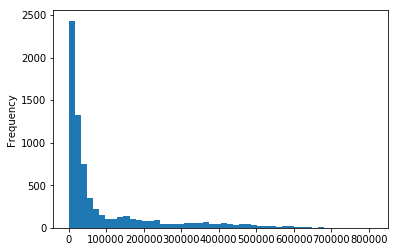

In [5]:
museums['visits'] = museums['visits'].str.replace(',', '')
museums.visits = museums.visits.astype('float64')
print(museums.visits.plot.hist(bins = 50))
print(museums.visits.describe())

AxesSubplot(0.125,0.125;0.775x0.755)


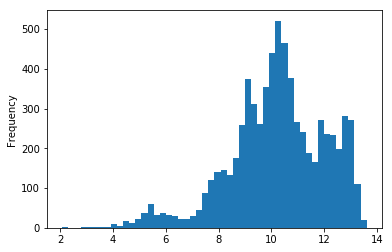

In [6]:
print(np.log(museums.visits).plot.hist(bins = 50))

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


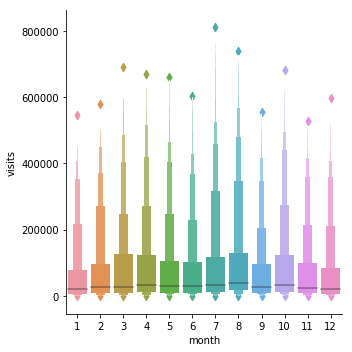

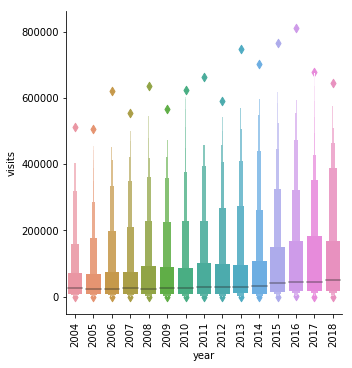

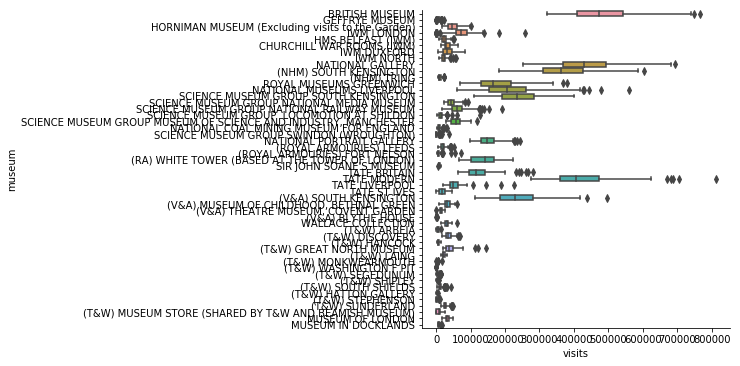

In [7]:
sns.catplot(x = 'month', y = 'visits', kind = 'boxen', data = museums)
sns.catplot(x = 'year', y = 'visits', kind = 'boxen', data = museums).set_xticklabels(rotation=90)
sns.catplot(x = 'visits', y = 'museum', kind = 'box', data = museums)

## 2. Models

### Metrics

As the target's distribution is highly skewed we shall use two metrics, the **mean absolute error** and the **median absolute error**. The mean absolute error is likely going to be affected by the presence of the outliers that will cause high errors on these few observations : therefore the value of the mean absolute error alone wouldn't adequately reflect the overall performance.

### Test, validation and training sets

Since we are interested in predicting the number of visits for years ahead we shall not randomly split the dataset but instead use the data from the last available year (2018) for the test set, the one before (2017) for the validation set and the remaining (2004-2016) for the training set. The models will be trained on this one and their hyperparameters will be adjusted on the validation set.

In [8]:
# test set
test = museums[museums['year'] == 2018]
y_test = test['visits']
test.drop(columns = ['visits'], inplace=True)
X_test = pd.get_dummies(test)

In [9]:
# validation set
validation = museums[museums['year'] == 2017]
y_val = validation['visits']
validation.drop(columns = ['visits'], inplace=True)
X_val = pd.get_dummies(validation)

In [10]:
# training set
training = museums[museums['year'] != 2017]
training = training[training['year'] != 2018]
y_train = training['visits']
training.drop(columns = ['visits'], inplace=True)
X_train = pd.get_dummies(training)

In [11]:
missing_cols = set(X_train.columns) - set(X_val.columns)
for c in missing_cols:
    X_val[c] = 0
X_val = X_val[X_train.columns]

In [12]:
X_train.shape

(6299, 63)

### Results

The **linear regression** model gives better results when using the natural logarithm for the response. The mean absolute error is about 26,900 people while the median absolute error is approximately 9200, which means that for 50 % of the predictions the error is under 9200.

The results are also better when using the log for the **gradient boosting machine** as well as some regularization to tackle overfitting : the mean absolute error falls at 22,200 people and for 50 % of the predictions the error is under 7100.

These models do better than naive predictions. Indeed if one was to use the **mean** or the **median** of the observations from the N year to predict the number of visits of the N + 1 year, the errors would be much worse : about 100,000 people on average and under 25,000 people in 50 % of the predictions.

In [13]:
# linear regression
reg = LinearRegression().fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
print('Training MAE : ', mean_absolute_error(y_train, y_train_pred)) # 20870
print('Training MAE : ', median_absolute_error(y_train, y_train_pred)) # 12342

y_val_pred = reg.predict(X_val)
print('Validation MAE : ', mean_absolute_error(y_val, y_val_pred)) # 29217
print('Validation MAE : ', median_absolute_error(y_val, y_val_pred)) # 19938

Training MAE :  20870.34973805366
Training MAE :  12342.0
Validation MAE :  29217.716145833332
Validation MAE :  19938.5


In [14]:
    # natural log
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
reg_log = LinearRegression().fit(X_train, y_train_log)
y_train_pred = reg_log.predict(X_train)
print('Training MAE : ', mean_absolute_error(y_train, np.exp(y_train_pred))) # 17731
print('Training MAE : ', median_absolute_error(y_train, np.exp(y_train_pred))) # 4983

y_val_pred = reg_log.predict(X_val)
print('Validation MAE : ', mean_absolute_error(y_val, np.exp(y_val_pred))) # 26891
print('Validation MAE : ', median_absolute_error(y_val, np.exp(y_val_pred))) # 9246

Training MAE :  17731.27590904598
Training MAE :  4983.385214958995
Validation MAE :  26891.663920968804
Validation MAE :  9246.368771484133


In [15]:
# light GBM 
y_train = pd.DataFrame(y_train)

params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "min_child_weight" : 50,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

d_train = lgb.Dataset(X_train, label = y_train["visits"])
clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Training MAE : ", mean_absolute_error(y_train, y_train_pred)) # 16267
print('Training MAE : ', median_absolute_error(y_train, y_train_pred)) # 7611

y_val_pred = clf.predict(X_val)
y_val_pred = pd.DataFrame(y_val_pred)
y_val_pred.describe()
y_val_pred.rename(columns = {0:'predictions'}, inplace = True)
y_val_pred.loc[y_val_pred['predictions'] < 0, 'predictions'] = 0
print("Validation MAE : ", mean_absolute_error(y_val, y_val_pred)) # 24016
print("Validation MAE : ", median_absolute_error(y_val, y_val_pred)) # 9749

Training MAE :  16267.341925487188
Training MAE :  7611.487574063365
Validation MAE :  24016.333122815355
Validation MAE :  9749.187127891444


In [16]:
    # natural log
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
d_train = lgb.Dataset(X_train, label = y_train_log["visits"])

clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Training MAE : ", mean_absolute_error(y_train, np.exp(y_train_pred))) # 13722
print('Training MAE : ', median_absolute_error(y_train, np.exp(y_train_pred))) # 4323

y_val_pred = clf.predict(X_val)
print("Validation MAE : ", mean_absolute_error(y_val, np.exp(y_val_pred))) # 22754
print("Validation MAE : ", median_absolute_error(y_val, np.exp(y_val_pred))) # 7200

Training MAE :  13722.548082693127
Training MAE :  4323.272503906621
Validation MAE :  22754.413011936413
Validation MAE :  7200.969815656157


In [17]:
params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "min_child_weight" : 50,
          "max_depth" : 17,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Training MAE : ", mean_absolute_error(y_train, np.exp(y_train_pred))) # 13451
print('Training MAE : ', median_absolute_error(y_train, np.exp(y_train_pred))) # 4350

y_val_pred = clf.predict(X_val)
print("Validation MAE : ", mean_absolute_error(y_val, np.exp(y_val_pred))) # 22170
print("Validation MAE : ", median_absolute_error(y_val, np.exp(y_val_pred))) # 7022

error = np.exp(y_val_pred) - y_val
error = np.abs(error)
error.describe()

Training MAE :  13451.374082858576
Training MAE :  4350.244918502474
Validation MAE :  22170.548741216935
Validation MAE :  7022.572401963422


count       384.000000
mean      22170.548741
std       35158.678532
min           3.745412
25%        2363.846776
50%        7022.572402
75%       24428.731426
max      239703.692965
Name: visits, dtype: float64

In [18]:
print(y_train.describe()) # mean 86948, median 27623
y_val = pd.DataFrame(y_val)
y_val['pred_mean'] = 86948 # predict the mean
y_val['pred_median'] = 27623 # predict the median

print(mean_absolute_error(y_val['visits'], y_val['pred_mean'])) # 109380
print(mean_absolute_error(y_val['visits'], y_val['pred_median'])) # 105377

print(median_absolute_error(y_val['visits'], y_val['pred_mean'])) # 71291
print(median_absolute_error(y_val['visits'], y_val['pred_median'])) # 24774

              visits
count    6299.000000
mean    86948.711383
std    132285.103136
min         8.000000
25%      9077.500000
50%     27623.000000
75%     95466.000000
max    811162.000000
109380.19010416667
105377.3828125
71291.5
24774.0


## 3. Evaluation

A new training set is created using the previous one as well as the validation set. The models are trained one last time with the hyperparameters found on the validation set and are evaluated on the test set, i.e. the number of visits in 2018. The natural log is taken for the response as we saw it provides better performance. 

For the **linear regression**, the mean absolute error is about 26,000 people and for 50 % of the predictions the error is under 9500 people.

For the **gradient boosting machine**, the mean absolute error is about 21,400 people and for 50 % of the predictions the error is under 7900 people. Therefore we recommend using the light gradient boosting machine to predict the number of visits in a given institution. 

It is likely that more accurate results could be obtained by distinguishing London institutions and non-capital institutions and creating two models, or adding a geographic feature in the model, or by removing a few outliers such as the British museum, the National Gallery and the Tate. More generally one would need more features to get better performance, such as the budget of the institution, the size of the collection, the number of exhibitions, etc.

In [19]:
# training set
training = museums[museums['year'] != 2018]
y_train = training['visits']
training.drop(columns = ['visits'], inplace=True)
X_train = pd.get_dummies(training)

In [20]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns]

In [21]:
    # regression with natural log
y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
reg_log = LinearRegression().fit(X_train, y_train_log)
y_train_pred = reg_log.predict(X_train)
print('Training MAE : ', mean_absolute_error(y_train, np.exp(y_train_pred))) # 17902
print('Training MAE : ', median_absolute_error(y_train, np.exp(y_train_pred))) # 5143

y_test_pred = reg_log.predict(X_test)
print('Test MAE : ', mean_absolute_error(y_test, np.exp(y_test_pred))) # 25796
print('Test MAE : ', median_absolute_error(y_test, np.exp(y_test_pred))) # 9490

Training MAE :  17902.957312720795
Training MAE :  5143.343019918801
Test MAE :  25796.718774177
Test MAE :  9490.174201788894


In [22]:
# light GBM 
y_train = pd.DataFrame(y_train)

params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "min_child_weight" : 50,
          "max_depth" : 17,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

y_train_log = y_train + 0.1 
y_train_log = np.log(y_train_log)
d_train = lgb.Dataset(X_train, label = y_train_log["visits"])

clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Training MAE : ", mean_absolute_error(y_train, np.exp(y_train_pred))) # 14040
print('Training MAE : ', median_absolute_error(y_train, np.exp(y_train_pred))) # 4488

y_test_pred = clf.predict(X_test)
print("Test MAE : ", mean_absolute_error(y_test, np.exp(y_test_pred))) # 21410
print("Test MAE : ", median_absolute_error(y_test, np.exp(y_test_pred))) # 7919
error = np.exp(y_test_pred) - y_test
error = np.abs(error)
error.describe()

Training MAE :  14040.789296963334
Training MAE :  4488.919528647191
Test MAE :  21410.301445763384
Test MAE :  7919.88654685465


count       384.000000
mean      21410.301446
std       31928.997600
min          13.974908
25%        2677.600916
50%        7919.886547
75%       25899.225170
max      232082.667407
Name: visits, dtype: float64